In [1]:
import numpy as np              # Python's standard numerical library
import matplotlib.pyplot as plt # Python's scientific visualization library
import pyidi                    # Python HSC data analysis library
import pickle as pk
import os
from pixel_setter2 import PixelSetter#, play_video, detect_peaks
from pixel_setter import play_video
from skimage import feature, measure
import importlib
from EMA_functions import *
import matplotlib.animation as animation
# from scipy.signal import convolve2d
from scipy.ndimage import generic_filter
root_drive_sim = os.path.normpath('G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Simulations')

c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Import video

In [9]:
file_root = r'G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Other/Blackledge_media'
file_name = "Arg.app.06_undmg_13.dec.2023_C001H001S0001.cihx"
EMA_structure = EMA_Structure(file_name)
EMA_structure.paths_to_check.append(file_root)
# video = EMA_structure.open_video_compressed(file_name, file_root)
video = EMA_structure.open_video(add_extension=False)

G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Other/Blackledge_media/Arg.app.06_undamaged_13.dec.2023\Arg.app.06_undmg_13.dec.2023_C001H001S0001.cihx


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\pyMRAW.py:103: UserWarning: Clipped footage! (Total frame: 1201, Original total frame: 5457)
  warnings.warn('Clipped footage! (Total frame: {}, Original total frame: {})'.format(cih['Total Frame'], cih['Original Total Frame'] ))


### Plot still frame in video

In [10]:
%matplotlib qt
sequential_image_n = 0
still_image = video.mraw[sequential_image_n]

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=False)
fig.savefig(os.path.join(root_drive_sim, 'still images', f'{file_name}_frame_sat0.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

fig, ax = EMA_structure.plot_still_frame(video, sequential_image_n, show_saturation=True)
fig.savefig(os.path.join(root_drive_sim, 'still images','with saturation', f'{file_name}_frame_sat1.png'), dpi=300, bbox_inches='tight')
# plt.close(fig)

first_frame = 1
ani = play_video(video, range(first_frame,video.N), interval=30)

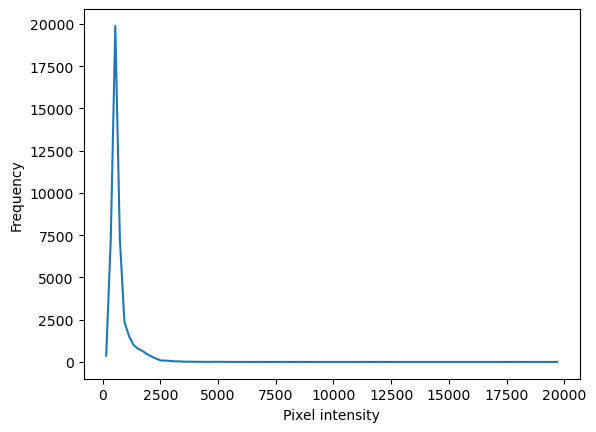

In [11]:
get_PI_histogram(still_image, remove_sides_fraction=0.4, save_path=os.path.join(root_drive_sim, 'histograms'), save_name=f'{file_name}_histogram.png')

In [26]:
reference_image = (0, 100)
roi_size        = (3, 3)
mean_image      = np.mean(video.mraw[reference_image[0]:reference_image[1]], axis=0)
# mean_image_copy = mean_image.copy()
# background_pixels = mean_image > 0.3 * np.max(mean_image)
# mean_image_copy[background_pixels] = np.max(mean_image_copy)
fig, ax = plt.subplots(2,1)
ax[0].imshow(mean_image, cmap='gray')
# ax[1].imshow(mean_image_copy, cmap='gray')
plt.show()

### Set pixels

In [27]:
# pix_set = PixelSetter(still_image, file_name = file_name)
eig_img = pix_set.find_eigenvalue_image(mean_image, roi_size[0], method = 'on_gradient' ) #'on_gradient'
# eig_img[background_pixels] = 0
fig, ax = plt.subplots()
ax.imshow(eig_img, cmap='gray')
plt.show()

In [ ]:
# pix_set = PixelSetter(still_image, file_name = file_name)
# top_values = np.sort(eig_img.flatten())[-100:]
# top_indices = np.unravel_index(np.argsort(eig_img, axis=None)[-100:], eig_img.shape)
# ax.scatter(top_indices[1], top_indices[0], c=top_values, cmap='viridis')
# plt.show()



In [24]:
pix_set = PixelSetter(still_image, file_name = file_name)
pix_set.set_neighborhood_size(4)
pix_set.choose_reference_centers()

### Combine the tracking points and exclude erroneous points

In [28]:
pix_set.combine_tracking_points()
tp = np.array(list(pix_set.tracking_points))
center = np.array(still_image.shape[:2])/2
center[1] = center[1] - 20
center[0] = center[0] - 40
radius = 0.88*np.linalg.norm(center)
distances = np.linalg.norm(tp - center, axis=1)
inside_web = (distances < radius)
hor_section = (tp[:, 1] > 2) & (tp[:, 1] < 1100)
ver_section = (tp[:, 0] > 15) & (tp[:, 0] < 490)
tp_lim = tp#tp[hor_section & ver_section & inside_web]

fig, ax = plt.subplots(figsize=(10, 10))

# plot tp
plt.scatter(center[1], center[0])
plt.scatter(tp[:, 1], tp[:, 0], c='red', s=10, label='tp')

# plot tp_lim with markers on top of tp
plt.scatter(tp_lim[:, 1], tp_lim[:, 0], c='green', s=5, label='tp_lim')
ax.set_xlim([0, still_image.shape[1]])
ax.set_ylim([still_image.shape[0] , 0])
ax.axis('equal')
# show the plot
plt.show()


### Save or open tracking points

In [29]:
np.savetxt(os.path.join(root_drive_sim, 'tp', f'tp_{file_name}.txt'), tp, fmt='%.18e', delimiter=',')
# tp = np.loadtxt(os.path.join(root_drive_sim, 'tp', f'tp_{file_name}.txt'), delimiter=',')

In [36]:
roi_size = (9,9)
reference_image = (0, 30)
video.set_points(tp_lim)
video.set_method('lk')
video.method.configure(roi_size=roi_size, reference_image=reference_image)  #, mraw_range=(1, video.N)
video.show_points()
# plt.gcf().savefig(os.path.join(root_drive_sim, 'still images','tp', f'{file_name}_frame_tp.png'), dpi=300, bbox_inches='tight')

In [37]:

# mraw_range = (sequential_image_n+1, 500)
# reference_image = (0, 30)
# roi_size_vec = [(3, 3), (5,5), (7, 7), (9, 9), (11, 11), (13, 13)]
# roi_size = (11, 11)
# video.method.configure(reference_image = reference_image, roi_size= roi_size)
# video.show_points()

d = video.get_displacements(processes = 12) #processes = -1
d = video.displacements

root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
path = os.path.join(root, file_name+f'_d_rs{str(roi_size)}_ri{str(reference_image)}'+'.pkl')
with open(path, 'wb') as f:
    pk.dump({'displacement':d, 'tracking points': tp_lim}, f)

# dd = np.diff(d, axis=1)
# last_10_zeros = np.any(dd[:, -10:, :] == 0, axis=(1,2))
# large_d = np.any(np.linalg.norm(d, axis=2) > 10, axis = 1)
# good_points = np.logical_not(last_10_zeros | large_d)

# first_frame = 1

# td = d +  tp_lim.reshape(len(tp_lim),1,2)
# ani = play_video(video, range(first_frame, video.N-1), interval=30, points=td[good_points, first_frame:, :])
# writer = animation.FFMpegWriter(fps=60)
# ani.save(os.path.join(root_drive_sim,'anim', f'{file_name}_d_rs{str(roi_size)}_ri{str(reference_image)}_anim_round_.mp4'), writer=writer)

--- Starting new analysis ---
 
Computation start: 2024-01-22 20:37:00.121736


c:\Users\thijsmas\AppData\Local\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


VBox()

Computation duration: 00:02:5.57
G:/.shortcut-targets-by-id/1k1B8zPb3T8H7y6x0irFZnzzmfQPHMRPx/Illimited Lab Projects/Research Projects/Spiders/Other/Blackledge_media/Arg.app.06_undamaged_13.dec.2023\Arg_pyidi_analysis\analysis_002\ analysis_002


In [ ]:
d = video.get_displacements(processes = 12)
# video.method.valid_points
d = video.displacements

### Save or open displacements and tracking points

In [19]:
root = 'C:/Users/thijsmas/Documents/GitHub/pyidi_data/'
path = os.path.join(root, file_name+f'_d_rs{str(roi_size)}_ri{str(reference_image)}'+'.pkl')
with open(path, 'wb') as f:
    pk.dump({'displacement':d, 'tracking points': tp_lim}, f)

### Animate the results

In [45]:
%matplotlib qt
dd = np.diff(d, axis=1)
last_10_zeros = np.any(dd[:, -10:, :] == 0, axis=(1,2))
large_d = np.any(np.linalg.norm(d, axis=2) > 10, axis = 1)
good_points = np.logical_not(last_10_zeros | large_d)

first_frame = 1

td = d +  tp_lim.reshape(len(tp_lim),1,2)
ani = play_video(video, range(400, video.N-1), interval=30, points=td[:, 1:, :], axis = [(453, 662), (662, 477)])
writer = animation.FFMpegWriter(fps=60)
ani.save(os.path.join(root_drive_sim,'anim', f'{file_name}_d_rs{str(roi_size)}_ri{str(reference_image)}_anim_.mp4'), writer=writer)

IndexError: index 1200 is out of bounds for axis 1 with size 1200

### Plot signals

In [ ]:
fig, ax = plt.subplots()
for point in np.arange(d.shape[0])[good_points][::5]: #[video.method.valid_points]
    ax.plot(np.arange(video.N), d[point, :, 0], label='point {} - dir 0'.format(point)) #video.info['Record Rate(fps)']*
    ax.plot(np.arange(video.N), d[point, :, 1], label='point {} - dir 1'.format(point)) #video.info['Record Rate(fps)']*
# ax.legend()
# ax.set_ylim(-50, 50)
ax.set_xlabel('frame number')
ax.set_ylabel('displacement [pixels]')